séparation du dataset (train / val / test 80–10–10)

In [3]:
import os
import random
import shutil
from pathlib import Path

# ==============================
# PARAMÈTRES GÉNÉRAUX
# ==============================

BASE_DIR = Path("../dataset yolo")
ALL_DIR = BASE_DIR / "all"
IMAGES_DIR = ALL_DIR / "images"
LABELS_DIR = ALL_DIR / "labels"

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# ==============================
# CRÉATION DES DOSSIERS YOLO
# ==============================

for split in ["train", "val", "test"]:
    (BASE_DIR / split / "images").mkdir(parents=True, exist_ok=True)
    (BASE_DIR / split / "labels").mkdir(parents=True, exist_ok=True)

# ==============================
# LISTE DES IMAGES
# ==============================

image_files = [
    f for f in os.listdir(IMAGES_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

print(f"Nombre total d'images : {len(image_files)}")

# ==============================
# SHUFFLE + SPLIT 80 / 10 / 10
# ==============================

random.shuffle(image_files)

total = len(image_files)
train_end = int(total * TRAIN_RATIO)
val_end = train_end + int(total * VAL_RATIO)

train_files = image_files[:train_end]
val_files = image_files[train_end:val_end]
test_files = image_files[val_end:]

print(f"Train : {len(train_files)} images")
print(f"Val   : {len(val_files)} images")
print(f"Test  : {len(test_files)} images")

# ==============================
# COPIE IMAGE + LABEL
# ==============================

def copy_split(files, split_name):
    for img_name in files:
        label_name = img_name.rsplit(".", 1)[0] + ".txt"

        src_img = IMAGES_DIR / img_name
        src_lbl = LABELS_DIR / label_name

        dst_img = BASE_DIR / split_name / "images" / img_name
        dst_lbl = BASE_DIR / split_name / "labels" / label_name

        if not src_lbl.exists():
            print(f"⚠️ Label manquant pour {img_name}")
            continue

        shutil.copy(src_img, dst_img)
        shutil.copy(src_lbl, dst_lbl)

# ==============================
# EXÉCUTION
# ==============================

copy_split(train_files, "train")
copy_split(val_files, "val")
copy_split(test_files, "test")

print("✅ Séparation du dataset terminée avec succès")


Nombre total d'images : 6586
Train : 5268 images
Val   : 658 images
Test  : 660 images
✅ Séparation du dataset terminée avec succès


Affichage des images 

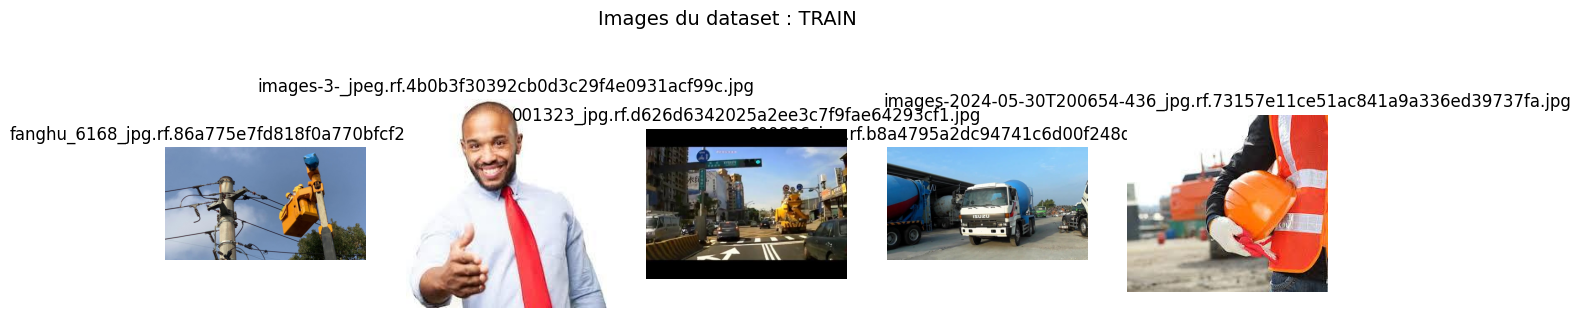

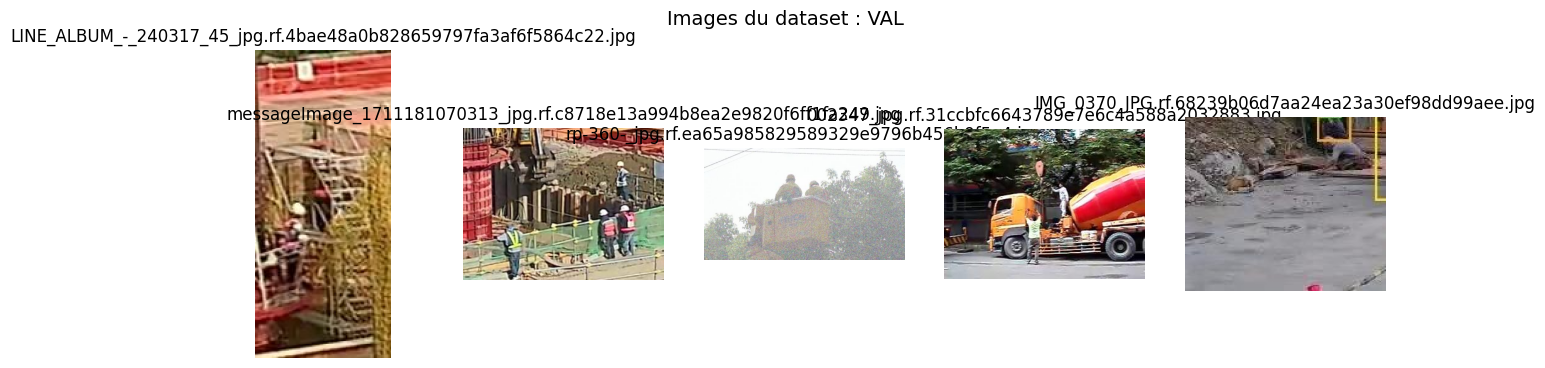

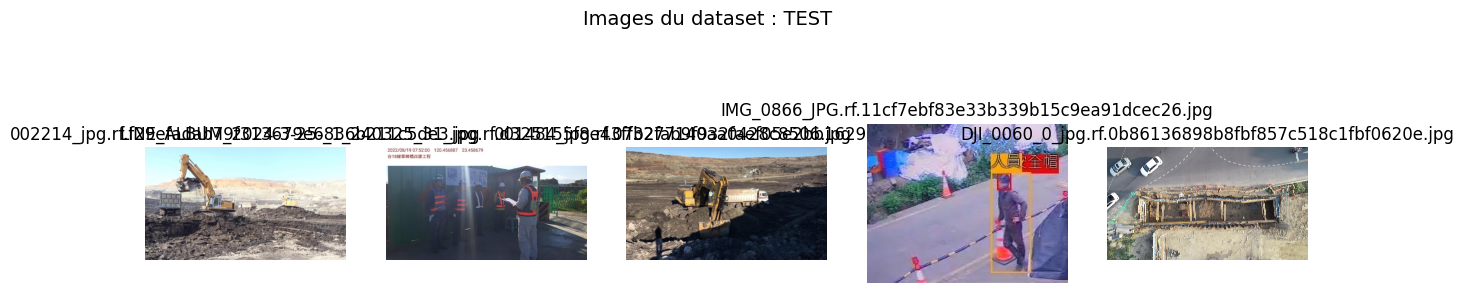

In [4]:
import matplotlib.pyplot as plt
import random
from pathlib import Path
from PIL import Image

# ==============================
# PARAMÈTRES
# ==============================

BASE_DIR = Path("../dataset yolo")
SPLITS = ["train", "val", "test"]
NB_IMAGES_AFFICHER = 5  # nombre d'images par split

# ==============================
# FONCTION D'AFFICHAGE
# ==============================

def afficher_images(split):
    images_dir = BASE_DIR / split / "images"
    image_files = list(images_dir.glob("*.jpg")) + \
                  list(images_dir.glob("*.png")) + \
                  list(images_dir.glob("*.jpeg"))

    if len(image_files) == 0:
        print(f"Aucune image trouvée dans {split}")
        return

    images_choisies = random.sample(
        image_files,
        min(NB_IMAGES_AFFICHER, len(image_files))
    )

    plt.figure(figsize=(15, 4))
    for i, img_path in enumerate(images_choisies):
        img = Image.open(img_path)
        plt.subplot(1, len(images_choisies), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_path.name)

    plt.suptitle(f"Images du dataset : {split.upper()}", fontsize=14)
    plt.show()

# ==============================
# EXÉCUTION
# ==============================

for split in SPLITS:
    afficher_images(split)


In [ ]:
# =========================================================
# INSTALLATION (si nécessaire)
# =========================================================
# !pip install ultralytics

from ultralytics import YOLO
from pathlib import Path
import pandas as pd

# =========================================================
# 1. CRÉATION DU data.yaml
# =========================================================

DATASET_DIR = Path("dataset")

data_yaml_content = f"""
path: {DATASET_DIR.resolve()}
train: train/images
val: val/images
test: test/images

names:
    0:Hardhat
    1:Mask
    2:NO-Hardhat
    3:NO-Mask
    4:NO-Safety Vest
    5:Person
    6:Safety Cone
    7:Safety Vest
    8:machinery
    9:utility pole
    10:vehicle
"""

data_yaml_path = DATASET_DIR / "data.yaml"
data_yaml_path.write_text(data_yaml_content)

print(" data.yaml créé avec succès")

# =========================================================
# 2. MODÈLES À ÉVALUER (3 par catégorie)
# =========================================================

models_to_test = {
    "YOLOv8": [
        "yolov8n.pt",
        "yolov8s.pt",
        "yolov8m.pt",
    ],
    "YOLO11": [
        "yolo11n.pt",
        "yolo11s.pt",
        "yolo11m.pt",
        "yolo11x.pt",
        "yolo11l.pt",
    ]
}

# =========================================================
# 3. PARAMÈTRES D’ENTRAÎNEMENT
# =========================================================

EPOCHS = 100
IMG_SIZE = 640
BATCH = 16

results = []

# =========================================================
# 4. ENTRAÎNEMENT + ÉVALUATION SUR TEST
# =========================================================

for family, model_list in models_to_test.items():
    for model_name in model_list:

        print(f"\n Entraînement {family} - {model_name}")

        model = YOLO(model_name)

        model.train(
            data=data_yaml_path,
            epochs=EPOCHS,
            imgsz=IMG_SIZE,
            batch=BATCH,
            project="runs_pfe",
            name=f"{family}_{model_name.replace('.pt','')}",
            exist_ok=True
        )

        print(f" Évaluation sur TEST : {family} - {model_name}")

        metrics = model.val(
            data=data_yaml_path,
            split="test"
        )

        results.append({
            "family": family,
            "model": model_name,
            "mAP50": metrics.box.map50,
            "mAP50-95": metrics.box.map,
            "precision": metrics.box.mp,
            "recall": metrics.box.mr
        })

# =========================================================
# 5. TABLEAU COMPARATIF FINAL
# =========================================================

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="mAP50-95", ascending=False)

print("\n COMPARAISON DES MODÈLES (TEST SET)")
display(df_results)


Evaluation des modèles.

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import torch
import gc

# =========================================================
# PARAMÈTRES
# =========================================================

MODELS_DIR = Path("../models")        # dossier contenant les modèles entraînés
DATA_YAML = Path("../dataset/data.yaml")


def evaluate_models(models_dir, data_yaml):
    results = []

    for model_path in sorted(models_dir.glob("*.pt")):
        print(f"\n Évaluation du modèle : {model_path.name}")

        try:
            model = YOLO(model_path)

            metrics = model.val(
                data=data_yaml,
                split="test",
                imgsz=640,
                batch=2,          # important pour ta GTX 960M
                device=0,
                plots=False,      # évite le KeyError
                verbose=False
            )

            results.append({
                "model": model_path.name,
                "mAP50": metrics.box.map50,
                "mAP50-95": metrics.box.map,
                "precision": metrics.box.mp,
                "recall": metrics.box.mr
            })

        except Exception as e:
            print(f" Échec pour {model_path.name} : {e}")

        finally:
            del model
            torch.cuda.empty_cache()

    return pd.DataFrame(results)

# =========================================================
# LANCEMENT DE L'ÉVALUATION
# =========================================================

df_results = evaluate_models(MODELS_DIR, DATA_YAML)

df_results = df_results.sort_values(by="mAP50-95", ascending=False)
display(df_results)

# =========================================================
# COURBES COMPARATIVES
# =========================================================

metrics_to_plot = ["mAP50", "mAP50-95", "precision", "recall"]

plt.figure(figsize=(12, 6))

for metric in metrics_to_plot:
    plt.plot(df_results["model"], df_results[metric], marker="o", label=metric)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Comparaison des performances des modèles (TEST SET)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================================================
# MEILLEUR MODÈLE GLOBAL
# =========================================================

best_model = df_results.iloc[0]
print(" MEILLEUR MODÈLE SELON mAP50-95")
print(best_model)



 Évaluation du modèle : best_yolo11l.pt
Ultralytics 8.3.247  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 960M, 4096MiB)
YOLO11l summary (fused): 190 layers, 25,287,793 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 261.554.2 MB/s, size: 38.9 KB)
val: Scanning D:\ETUDEµ\CITE\ETAPE4\PROJET DE FIN DE SESSION\TOURMANT 1\dataset\test\labels.cache... 660 images, 18 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 660/660 686.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 330/330 4.0it/s 1:23<0.2ss
                   all        660       6419      0.933      0.725      0.793      0.616
Speed: 2.0ms preprocess, 117.2ms inference, 0.0ms loss, 2.2ms postprocess per image

 Évaluation du modèle : best_yolo11m.pt
Ultralytics 8.3.247  Python-3.12.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce GTX 960M, 4096MiB)
YOLO11m summary (fused): 125 layers, 20,038,513 parameters, 0 gradients, 6

,model,mAP50,mAP50-95,precision,recall
4,best_yolo11x.pt,0.831173,0.694181,0.955491,0.763653
0,best_yolo11l.pt,0.793108,0.616090,0.933012,0.725311
1,best_yolo11m.pt,0.783834,0.603423,0.919900,0.716641
3,best_yolo11s.pt,0.717830,0.497457,0.873650,0.648792
2,best_yolo11n.pt,0.501649,0.310814,0.681715,0.443898


<Figure size 1200x600 with 1 Axes>

 MEILLEUR MODÈLE SELON mAP50-95
model        best_yolo11x.pt
mAP50               0.831173
mAP50-95            0.694181
precision           0.955491
recall              0.763653
Name: 4, dtype: object
